In [2]:

import os
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage import gaussian_filter
from scipy.io import loadmat
from matplotlib import cm
from scipy.ndimage import gaussian_filter
import nbimporter

import Lab_2_VA

from Achanta import Achanta

PATH_DATA = "C:/Master/PC/VAproject/FIGRIM/FIGRIM"


# Experiment-dependant constants
RESO_X = 1000
RESO_Y = 1000
FACTOR_X = RESO_X/270
FACTOR_Y = RESO_Y/203

In [88]:
pip install opencv-python


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
def get_files_all_observers(dir_path, img_name):
    print("dir path "+dir_path)
    print("img_name "+img_name)
    """
    List all eye-tracking data files related to a particular image.
    
    :param dir_path: str, the path to the directory in which the dataset is stored.
    :param img_name: str, the name of the image for which we want to gather eye-tracking data.
                     This must be of the form img.trn.xxx or img.tst.xxx
    :return list_all_files: list, containing the paths to all the relevant eye-tracking files.
    """
    list_all_files = glob.glob(os.path.join(dir_path, 'Data/**/*' + img_name + '.*'), recursive=True)
    assert list_all_files, "List of eye-tracking files seem to be empty. Check directory or image name."
    return list_all_files

NameError: name 'dir_path' is not defined

In [90]:
def create_examples(img_size, sigma_filter, locations):
    img = np.zeros((img_size, img_size))
    for loc in zip(locations):
        img[loc[0], loc[1]] = 1
    img = gaussian_filter(img, sigma=sigma_filter)
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

In [5]:
def create_fixmap(list_obs_files, img_w, img_h, factor_x, factor_y, t_begin=0, t_end=15):
    """
    Create a fixation map based on raw eye-tracking data.
    
    :param list_obs_files: list, a list of paths to the eye-tracking files of each observer for the considered image
    :param img_w: int, the width of the image, in pixels
    :param imw_h: int, the height of the image, in pixels
    :param factor_x: float, the ratio of the horizontal resolution to the horizontal size of the screen used in the eye-tracking experiment
    :param factor_y: float, the ratio of the vertical resolution to the vertical size of the screen used in the eye-tracking experimen
    :param t_begin: float, the start of the time slice to consider, in s.
    :param t_end: float, the end of the time slice to consider, in s.
    :return fixmap: numpy array, the fixation map.
    """
    # First, let's initialize the fixation map.
    fixmap = np.zeros((img_h, img_w))
    sigma_filter = 5
    for obs in list_obs_files:
    
        # We will read the files and store them in a pandas dataframe.
        # If you are not familiar with pandas : https://pandas.pydata.org/docs/user_guide/index.html
        mat_data = loadmat(obs)
        # Access the 'i05june05_static_street_boston_p1010785' key
        data_key = mat_data['fixLocs']
        # Access the 'DATA' field within 'i05june05_static_street_boston_p1010785'
       
        for x in range(len(data_key)):
            for y in range(len(data_key[x])):
                if data_key[x][y] != 0 and 0 < x < img_h and 0 < y < img_w:
                    fixmap[x, y] = 1
        fixmap = gaussian_filter(fixmap, sigma=sigma_filter)
        fixmap = (fixmap - np.min(fixmap)) / (np.max(fixmap) - np.min(fixmap))
                    
    
    return fixmap



In [92]:
def compute_ppda(distance, h_res, v_res, screen_w, screen_h):
    """
    Compute the number of pixels per degree of visual angle based on the experimental conditions.
    
    :param distance: int, the distance between the observer and the screen (in mm)
    :param h_res: int, the horizontal resolution of the screen
    :param v_res: int, the vertical resolution of the screen
    :param screen_w: int, the width of the screen (in mm)
    :param screen_h: int, the height of the screen (in mm)
    :return horizontal_ppda: float, the number of pixel per degree of visual angle
    """    
    ###### TODO ######
    pxl_density_x = h_res / screen_w
    pxl_density_y = v_res / screen_h
    
    # print(str(pxl_density_x) + ' ' + str(pxl_density_y))
    
    d = 2 * distance * math.tan(np.deg2rad(0.5))
    horizontal_ppda = d * ((pxl_density_x + pxl_density_y) / 2)
    
    
    return horizontal_ppda

In [93]:
def salmap_from_fixmap(fixmap, ppda):
    """
    Generate a visual saliency map, based on the fixation map.
    
    :param fixmap: numpy array, the fixation map
    :param ppda: float, the number of pixels per degree of visual angle
    :return salmap: numpy array, the visual saliency map
    """
    
    sigma = ppda / np.sqrt(2)
    
    salmap = gaussian_filter(fixmap, sigma=sigma)

    ###### TODO ######
    return salmap

In [94]:
achanta = Achanta()

In [95]:
files = get_files_all_observers(PATH_DATA, "amusement_park/sun_bswufzcqfgifnykp")
fixmap = create_fixmap(files, RESO_X, RESO_Y, FACTOR_X, FACTOR_Y)
img = mpimg.imread(os.path.join(PATH_DATA, "Stimuli/amusement_park/sun_bswufzcqfgifnykp.jpg"))
ppda = compute_ppda(415.8, RESO_X, RESO_Y, 270, 203)
salmap = salmap_from_fixmap(fixmap, ppda)
salmap_achanta = achanta.get_salmap(img)

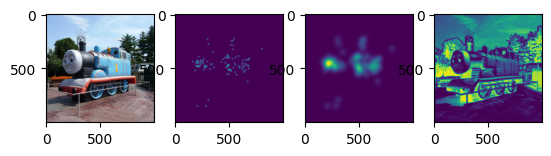

In [96]:
fig, axarr = plt.subplots(1, 4)
axarr[0].imshow(img)
axarr[1].imshow(fixmap)
axarr[2].imshow(salmap)
axarr[3].imshow(salmap_achanta)

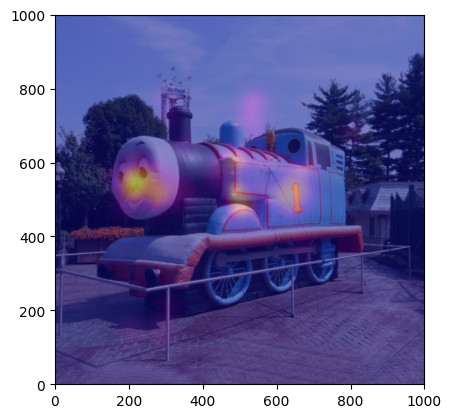

In [97]:
extent = [0, fixmap.shape[1], 0, fixmap.shape[0]]
plt.imshow(img, cmap = 'viridis', extent = extent)
plt.imshow(salmap, cmap = 'plasma', alpha = 0.5, extent = extent)
plt.show()

In [11]:
# List of folder names
folder_names = ["airport_terminal", "amusement_park", "badlands", "bathroom", "bedroom", "bridge", "castle", "cockpit", "conference_room", 
                "dining_room", "golf_course", "highway", "house", "kitchen", "lighthouse", "living_room", "mountain", "pasture",
                "playground", "skyscraper", "tower"] 

folder_names = ["airport_terminal", "amusement_park"] 

# Define function to calculate metrics
def calculate_metrics_for_folder(folder_name):
   
    number_of_images = 0
    Borji_mean = 0
    K1_mean = 0
    NSS_mean = 0
    CC_mean = 0
    similarity_mean = 0
    
    # Define the path to the folder
    full_folder_path = os.path.join(PATH_DATA+"/Stimuli", folder_name)

    # Get all image files in the folder
    folder_files = [f for f in os.listdir(full_folder_path) if f.endswith(".jpg")]
    print(folder_files)
    print(full_folder_path)
    # Iterate through each file in the folder
    for file_name in folder_files:
        file_path = os.path.join(full_folder_path, file_name)
        print("File " + file_path)
        files = get_files_all_observers(PATH_DATA, folder_name + "/" + file_name.split('.')[0])
        # Create fixation map, read image, etc. (use your existing code)
        fixmap = create_fixmap(files, RESO_X, RESO_Y, FACTOR_X, FACTOR_Y)
        img = mpimg.imread(file_path)
        ppda = compute_ppda(415.8, RESO_X, RESO_Y, 270, 203)
        salmap_achanta = achanta.get_salmap(img)

        # Calculate metrics
        score1b, _, _ = Lab_2_VA.AUC_Borji(saliencyMap=salmap_achanta, fixationMap=fixmap)
        klScore = Lab_2_VA.kl_divergence(saliencyMap=salmap_achanta, baselineMap=salmap)
        nssScore1 = Lab_2_VA.NSS(saliencyMap=salmap_achanta, fixationMap=fixmap)
        ccScore = Lab_2_VA.CC(saliencyMap1=salmap_achanta, saliencyMap2=salmap)
        similarityScore = Lab_2_VA.similarity(pred_sal=salmap_achanta, gt_sal=salmap)

        # Update mean values
        number_of_images += 1
        Borji_mean += score1b
        K1_mean += klScore
        NSS_mean += nssScore1 
        CC_mean += ccScore
        similarity_mean += similarityScore
    
    # Calculate means for the folder
    Borji_mean /= number_of_images
    K1_mean /= number_of_images
    NSS_mean /= number_of_images
    CC_mean /= number_of_images
    similarity_mean /= number_of_images

    return Borji_mean, K1_mean, NSS_mean, CC_mean, similarity_mean

# Iterate through each folder and calculate metrics
for folder_name in folder_names:
    metrics_results = calculate_metrics_for_folder(folder_name)
    print(f"Metrics for folder '{folder_name}': {metrics_results}")


['sun_aaotjvucbfgmtzjj.jpg', 'sun_abrlnvzmqklirrnl.jpg', 'sun_actnsdjpqgtzjwcw.jpg', 'sun_aebnrieebfokejpz.jpg', 'sun_agyrffqdcxgchrqc.jpg', 'sun_aiaymzoqhwcskhet.jpg', 'sun_ajbphdqxyiykpfzz.jpg', 'sun_amanjegobfvstisf.jpg', 'sun_amsbquzaxygzngfl.jpg', 'sun_amttmxsdbjiocycj.jpg', 'sun_amzglrkivnzzcqvv.jpg', 'sun_apdyivawxenhdhww.jpg', 'sun_apsgugrdnfnnnvup.jpg', 'sun_aqovleaxrjqeddyp.jpg', 'sun_aqyazfjzmeyzhrel.jpg', 'sun_aqzpnmfqtgrpoczc.jpg', 'sun_arahdppusymomreh.jpg', 'sun_atibjtzuhjtfxauq.jpg', 'sun_atvvhulltzsmwfsi.jpg', 'sun_aucikzzfjeeqyewt.jpg', 'sun_aukmeobryrcehyvo.jpg', 'sun_auyvxoybsqfsxbyq.jpg', 'sun_avcpfpykytbdwitw.jpg', 'sun_awmodvmqonpeudqi.jpg', 'sun_awznnowvdgitriji.jpg', 'sun_axtrtuvronnaijwz.jpg', 'sun_aycegtgkgmjfcynh.jpg', 'sun_ayjpepopjfoujmxv.jpg', 'sun_azylimozzzlvnplm.jpg', 'sun_btxbetsunlpwrnhs.jpg']
C:/Master/PC/VAproject/FIGRIM/FIGRIM/Stimuli\airport_terminal
File C:/Master/PC/VAproject/FIGRIM/FIGRIM/Stimuli\airport_terminal\sun_aaotjvucbfgmtzjj.jpg
dir p

AssertionError: List of eye-tracking files seem to be empty. Check directory or image name.